In [1]:
import pandas as pd
import numpy as np
import re
import gc
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

df_train_ident = pd.read_csv('data/train_identity.csv.gz')
df_train_transact = pd.read_csv('data/train_transaction.csv.gz')
df_test_ident = pd.read_csv('data/test_identity.csv.gz')
df_test_transact = pd.read_csv('data/test_transaction.csv.gz')

import pickle
with open('df_train_ident.pickle','rb') as k:
    df_train_ident = pickle.load(k)
with open('df_train_transact.pickle','rb') as l:
    df_train_transact = pickle.load(l)
with open('df_test_ident.pickle','rb') as m:
    df_test_ident = pickle.load(m)
with open('df_test_transact.pickle','rb') as n:
    df_test_transact = pickle.load(n)

# Using TransactionID as index for both data.
df_train_ident.set_index('TransactionID',inplace=True)
df_train_transact.set_index('TransactionID',inplace=True)
df_test_ident.set_index('TransactionID',inplace=True)
df_test_transact.set_index('TransactionID',inplace=True)


df_train = pd.merge(df_train_transact, df_train_ident, on='TransactionID', how='left')
df_test = pd.merge(df_test_transact, df_test_ident, on='TransactionID', how='left')

In [2]:
with open('df_test_leftMerged.pickle','rb') as f:
    df_test = pickle.load(f)
with open('df_train_leftMerged.pickle','rb') as g:
    df_train = pickle.load(g)

In [3]:
def preprocessing(line):
    line = str(line).lower()
    line = re.sub(r"[^\w\s]", '_', line)
    line = re.sub(r"\s+", ' ', line)
    return line

# Feature engineering

In [4]:
#Convert TransactionDT to a weekday number.
df_train['WD'] = pd.to_timedelta(df_train['TransactionDT'],unit='seconds')+np.datetime64('2015-01-01')
df_test['WD']  = pd.to_timedelta(df_test['TransactionDT'],unit='seconds')+np.datetime64('2015-01-01')
df_train['WD'] = df_train['WD'].dt.dayofweek
df_test['WD'] = df_test['WD'].dt.dayofweek

In [5]:
#Break up resolution string of format num1 x num2 into 2 columns (num1 and num2)
# each being an int.
df_train['res1'] = df_train[~pd.isnull(df_train['id_33'])]['id_33'].apply(lambda x: str(x).split('x')[0])
df_train['res2'] = df_train[~pd.isnull(df_train['id_33'])]['id_33'].apply(lambda x: str(x).split('x')[1])
df_test['res1'] = df_test[~pd.isnull(df_test['id_33'])]['id_33'].apply(lambda x: str(x).split('x')[0])
df_test['res2'] = df_test[~pd.isnull(df_test['id_33'])]['id_33'].apply(lambda x: str(x).split('x')[1])

# Data Prep

In [6]:
# Collect all columns which have more than 25% as no-values/NaN
miss_val_threshold = 0.25

col_to_del = []

for c in df_train.columns:
    if df_train[c].isnull().sum() > df_train.shape[0]*miss_val_threshold:
        col_to_del.append(c)

for c in df_test.columns:
    if df_train[c].isnull().sum() > df_test.shape[0]*miss_val_threshold:
        if c not in col_to_del:
            col_to_del.append(c)
        
col_to_del.append('TransactionID')
col_to_del.append('TransactionDT')

In [7]:
df_test_transactionids = df_test['TransactionID']
df_train.drop(columns=col_to_del, inplace = True)
df_test.drop(columns=col_to_del, inplace = True)

In [8]:
df_train.fillna(-999, inplace= True)
df_test.fillna(-999, inplace= True)

In [9]:
# before optimization
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 181 entries, isFraud to WD
dtypes: float64(174), int64(3), object(4)
memory usage: 820.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 180 entries, TransactionAmt to WD
dtypes: float64(174), int64(2), object(4)
memory usage: 699.7+ MB


In [10]:
col_int16 = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
           'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
           'D1', 'D10', 'D15', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
           'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
           'V31', 'V32', 'V33', 'V34', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59',
           'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 
           'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79',
           'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89',
           'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99',
           'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109',
           'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119',
           'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129',
           'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279',
           'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289',
           'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299',
           'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309',
           'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319',
           'V320', 'V321']

In [11]:
for c in col_int16:
    df_train[c] = df_train[c].astype(np.int16)
    df_test[c] = df_test[c].astype(np.int16)

In [12]:
# one-hot-encoding of categorical values in train dataset
col_dummies = ['ProductCD', 'card4', 'card6', 'P_emaildomain']

for c in col_dummies:
    df_train[c] = pd.get_dummies(df_train[c])
    df_test[c] = pd.get_dummies(df_test[c])
    
# drop one-hot-encoded features     
df_train.drop(columns=col_dummies, inplace = True)  
df_test.drop(columns=col_dummies, inplace = True) 

In [13]:
# after optimization
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 177 entries, isFraud to WD
dtypes: float64(1), int16(174), int64(2)
memory usage: 214.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 176 entries, TransactionAmt to WD
dtypes: float64(1), int16(174), int64(1)
memory usage: 179.8 MB


# free memory
del df_train_ident, df_train_transact, df_test_ident, df_test_transact
gc.collect()

In [14]:
def splitData():
    df_train_neg = df_train.loc[df_train['isFraud'] == 0]
    df_train_pos = df_train.loc[df_train['isFraud'] == 1]
    
    split = 0.2
    x_train_pos, x_val_pos = train_test_split(df_train_pos, test_size=split, random_state=42)
    x_train_neg, x_val_neg = train_test_split(df_train_neg, test_size=split, random_state=42)
    
    #downsample the majority to achieve 1:1 class distribution
    x_train_neg = x_train_neg.sample(frac=1/27)
    x_val_neg   = x_val_neg.sample(frac=1/27)
    
    #combine and reshuffle training and validation sets
    x_train = (x_train_pos.append(x_train_neg)).sample(frac=1)
    x_val   = (x_val_pos.append(x_val_neg)).sample(frac=1)
    
    y_train = x_train.pop('isFraud')
    y_val   = x_val.pop('isFraud')
    
    return x_train, x_val, y_train, y_val

In [15]:
X = df_train.drop('isFraud',axis=1)
y = df_train['isFraud']

In [16]:
# Create training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
X_train, X_test, y_train, y_test = splitData()

# Create the classifier: logreg
logreg = LogisticRegression()

# T R A I N
# Fit the classifier to the training data
logreg.fit(X_train,y_train)

C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# P R E D I C T
# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

#
# E V A L U A T E
#
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3097 1124]
 [1307 2826]]
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      4221
           1       0.72      0.68      0.70      4133

   micro avg       0.71      0.71      0.71      8354
   macro avg       0.71      0.71      0.71      8354
weighted avg       0.71      0.71      0.71      8354



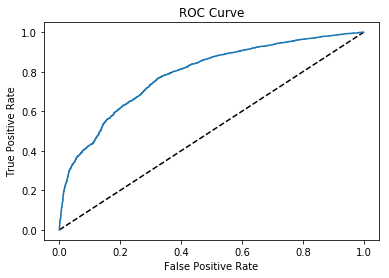

In [18]:
# R O C 
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [19]:
# A U C
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X,y,scoring='roc_auc',cv=5)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.7871557837648027


C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

AUC scores computed using 5-fold cross-validation: [0.66772456 0.69440896 0.68726532 0.70510022 0.68887548]


C:\Users\myneni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
y_real_pred = logreg.predict_proba(df_test)[:,1]

In [21]:
results_dict = dict(zip(df_test_transactionids.to_list(),y_real_pred))

In [22]:
items = results_dict.items()
results_df = pd.DataFrame({'TransactionID': [i[0] for i in items], 'isFraud': [i[1] for i in items]})

In [23]:
results_df.to_csv('results_downsample1_wkdaynum.csv',index=False)

results_df1 = pd.DataFrame.from_records(results_df,columns=['TransactionID','isFraud'],nrows=len(results_df))